# Coding CNNs from Scratch with Pytorch

In this assignment you will code a famous CNN architecture AlexNet (https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) to classify images from the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 10 classes of natural images such as vehicles or animals. AlexNet is a landmark architecture because it was one of the first extremely deep CNNs trained on GPUs, and achieved state-of-the-art performance in the ImageNet challenge in 2012. 


A lot of code will already be written to familiarize yourself with PyTorch, but you will have to fill in parts that will apply your knowledge of CNNs. Additionally, there are some numbered questions that you must answer either in a separate document, or in this notebook. Some questions may require you to do a little research. To type in the notebook, you can insert a text cell. 

Let's start by installing PyTorch and the torchvision package below. Due to the size of the network, you will have to run on a GPU. So, click on the Runtime dropdown, then Change Runtime Type, then GPU for the hardware accelerator. 

In [ ]:
!pip install pytorch
!pip install torchvision

  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-bir4__92/pytorch/setup.py'"'"'; __file__='"'"'/tmp/pip-install-bir4__92/pytorch/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-upc2d0uf/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device('cuda')
    
print(device)

cuda


### 1. In the following cell, we are employing something called "data augmentation" with random horizontal and vertical flips. So when training data is fed into the network, it is ranadomly transformed. What are advantages of this?

### 2. We normalize with the line transforms.Normalize((0.5,), (0.5,)). What are the benefits of normalizing data? 




Answers:
1. By randomly transforming images (augmentation) this allows the model to learn to focus and recognize different features unique to the image that cause it to fall into its specified category. It also mirrors images in the real world which may be seen at different angles or with part of the image cut-off, so recognizing features in various settings is important for generalizability of model accuracy. 
2. This reduces noise in the data which often comes in a wide scale of values. By reducing the scale of data we enusre that calculations (like gradient descent in this case) can move evenly and smoothly through the data. 

In [26]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from math import ceil

BATCH_SIZE = 100


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5), 
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

torch.manual_seed(43)
val_size = 10000
train_size = len(trainset) - val_size


train_ds, val_ds = random_split(trainset, [train_size, val_size])
print(len(train_ds), len(val_ds))


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_steps =  ceil(len(train_ds) / BATCH_SIZE)
num_steps

Files already downloaded and verified
Files already downloaded and verified
40000 10000


400

In [27]:
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testset, BATCH_SIZE)

You can insert an integer  into the code trainset[#insert integer] to visualize images from the training set. Some of the images might look weird because they have been randomly flipped according to our data augmentation scheme. 

Label (numeric): 3
Label (textual): cat


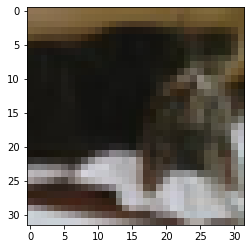

In [28]:
img, label = trainset[9]
plt.imshow((img.permute((1, 2, 0))+1)/2)
print('Label (numeric):', label)
print('Label (textual):', classes[label])

Now comes the fun part. You will have to put in the correct parameters into different torch.nn functions in order to convolve and downsample the image into the correct dimensionality for classification. Think of it as a puzzle. You will insert the parameters where there is a comment #TODO. 

In [29]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 3,
                      out_channels = 64,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
            
        #Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        #we must flatten our feature maps before feeding into fully connected layers
        x = x.contiguous().view(x.size(0), -1)
        x = self.classifier(x)
        return x

Below we are initializing our model with a weight scheme.

In [30]:
net = Discriminator()

def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
net = net.to(device)

net.apply(weights_init)



Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0

# 3. Notice above in our network architecture, we have what are called "Dropout" layers. What is the point of these?

Answer: 
3. Dropout is performed in an attempt to reduce overfitting. By randomly dropping out a certain percentage of the nodes during training, you are slightly changing the architecture of the learner during in the learning process so that no one feature is given too much consideration during model use. In a way, it is like ensemble learning using slightly different model configurations to avoid overfitting but doing it within the architecture of a single model. 

Defining our cost/loss function, which is cross-entropy loss. We also define our optimizer with hyperparameters: learning rate and betas. 

In [31]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=0.0002,
    betas = (0.5, 0.999)
)


Below we actually train our network. Run for just 10 epochs. It takes some time. Wherever there is the comment #TODO, you must insert code.

In [32]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)     #pass input data into network to get outputs
        loss = criterion(outputs, labels)
        loss.backward()  #calculate gradients
        optimizer.step() #take gradient descent step

        
        running_loss += loss.item()
            
    
    print("E:{}, Train Loss:{}".format(
                epoch+1,
                running_loss / num_steps
            )
        )
        
        
        
    #validation
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
            loss = criterion(outputs, labels)       #calculate validation loss (this might be wrong?)
            val_loss += loss.item()
    val_loss /=num_steps
    print('Accuracy of 10000 val images: {}'.format( correct / total))
    print('Val Loss: {}'.format( val_loss))

print('Finished Training')

E:1, Train Loss:1.9288364332914352
Accuracy of 10000 val images: 0.355
Val Loss: 0.42403154850006103
E:2, Train Loss:1.5849536576867103
Accuracy of 10000 val images: 0.4566
Val Loss: 0.3680096334218979
E:3, Train Loss:1.4078839853405953
Accuracy of 10000 val images: 0.5052
Val Loss: 0.3359279668331146
E:4, Train Loss:1.2896445558965206
Accuracy of 10000 val images: 0.516
Val Loss: 0.3300463604927063
E:5, Train Loss:1.1984027618169784
Accuracy of 10000 val images: 0.5648
Val Loss: 0.30234865307807923
E:6, Train Loss:1.1177772334218026
Accuracy of 10000 val images: 0.5976
Val Loss: 0.2807721322774887
E:7, Train Loss:1.059584570080042
Accuracy of 10000 val images: 0.6061
Val Loss: 0.2738793417811394
E:8, Train Loss:0.9971867692470551
Accuracy of 10000 val images: 0.6125
Val Loss: 0.272986953407526
E:9, Train Loss:0.9445476667582988
Accuracy of 10000 val images: 0.6341
Val Loss: 0.25515799775719644
E:10, Train Loss:0.8975600008666516
Accuracy of 10000 val images: 0.6381
Val Loss: 0.2567937

## 4. If we train for more epochs, our accuracy/performance will increase. What happens if we train for too long though? What method can be employed to mitigate this?

## 5. Try increasing learning rate and look at the metrics for training and validation data? What do you notice? Why do think this is happening?



Answers: 
4. Early stopping: this is the process of continuing to train the model until the performance on the validation set during training starts to degrage (loss increases), which is a sign that anymore training may lead to overfitting. 
5. The accuracy improves more quickly, whcih makes sense as we are moving closer to them minimum value with each iteration of the gradient descent... the danger is that if we make the learning rate too large we will over the step the global minimum with each correction and never converge on the right answer. However if the rate is too low it will take too long and too many epochs to reach the answer, so a rate that balances these two conditions has to be chosen. 

We can see the performance on the testing set now. 

In [33]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of 10000 test images: {}'.format( correct / total))

Accuracy of 10000 test images: 0.6374
